# HDF5 Dataset Builder

Use this notebook only to create HDF5 datasets from raw audio. Training, evaluation, and inference remain in the main notebook.


In [11]:
# Imports and configuration

import os
import json
import yaml
import time
import math
import random
import h5py
import librosa
import numpy as np
from pathlib import Path
from collections import defaultdict

# Paths (edit these)
BASE_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
# Notebook is inside IML-PW, so use local folders
data_root = BASE_DIR / "Recordings_1"
output_dir = BASE_DIR / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)

if not data_root.exists():
    alt = BASE_DIR.parent / "IML-PW" / "Recordings"
    if alt.exists():
        print(f"⚠️ Using fallback data_root: {alt}")
        data_root = alt
    else:
        raise FileNotFoundError(f"Recordings folder not found. Checked: {data_root} and {alt}")

print(f"📁 data_root: {data_root}")
print(f"📁 output_dir: {output_dir}")

# ============================================================================
# LABELING MODE SELECTION
# ============================================================================
# Choose ONE of the following modes:
#
# "binary"     - Labels: 0 (outsider), 1 (group member)
#                Use case: Simple access control (allowed vs not allowed)
#                Model output: 2 classes
#
# "speaker_id" - Labels: 0, 1, 2, 3, ... (unique speaker IDs)
#                Use case: Speaker identification + access control via embeddings
#                Model output: N classes (one per speaker)
#                Recommended for: Identifying WHO is speaking + access control
# ============================================================================

LABEL_MODE = "binary"  # Options: "binary" or "speaker_id"

print(f"\n🏷️  LABEL MODE: {LABEL_MODE}")
if LABEL_MODE == "binary":
    print("   → Labels: 0=outsider, 1=group member")
    print("   → Model: Binary classification (2 classes)")
elif LABEL_MODE == "speaker_id":
    print("   → Labels: Unique speaker IDs (0, 1, 2, ...)")
    print("   → Model: Multi-class speaker recognition + embedding verification")

# Audio / feature params
sr = 16000
n_mels = 64
n_fft = 2048
hop_length = 512
chunk_duration = 1.0  # seconds

# Augmentation toggles
WITH_NOISE = True
WITH_SPEED = True
WITH_VTLP = True
WITH_SPECTRAL = True

AGGRESIVE_AUG_CLASS_1 = True

random_seed = 42

SUPPORTED_EXTS = (".wav", ".mp3", ".m4a", ".wma")
np.random.seed(random_seed)
random.seed(random_seed)

📁 data_root: c:\Users\pczec\Desktop\Studia\SEM5\IML\IML-PW\Recordings_1
📁 output_dir: c:\Users\pczec\Desktop\Studia\SEM5\IML\IML-PW\outputs

🏷️  LABEL MODE: binary
   → Labels: 0=outsider, 1=group member
   → Model: Binary classification (2 classes)


In [12]:
# ==========================================================
# INFERENCE-COMPATIBLE PREPROCESSING CLASS
# ==========================================================
from scipy.signal import butter, lfilter
from pydub import AudioSegment


class AudioPreprocessor:
    """Lightweight preprocessing pipeline."""
    def __init__(self, sr=16000, n_mels=64, n_fft=2048, hop_length=512,
                 chunk_duration=3.0, remove_silence=True, normalize=True,
                 lowcut=None, highcut=None, filter_order=4):
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.chunk_duration = chunk_duration
        self.remove_silence = remove_silence
        self.normalize = normalize
        self.lowcut = lowcut
        self.highcut = highcut
        self.filter_order = filter_order

    def load_audio(self, path):
        """Load and resample audio."""
        audio = AudioSegment.from_file(path)
        if audio.channels > 1:
            audio = audio.set_channels(1)

        samples = np.array(audio.get_array_of_samples()).astype(np.float32)
        samples /= (1 << (8 * audio.sample_width - 1))

        if audio.frame_rate != self.sr:
            samples = librosa.resample(samples, orig_sr=audio.frame_rate, target_sr=self.sr)

        return samples

    def trim_silence(self, samples, top_db=30):
        """Remove silence from audio."""
        non_silent, _ = librosa.effects.trim(samples, top_db=top_db)
        return non_silent

    def normalize_volume(self, samples):
        """Normalize audio volume."""
        max_val = np.max(np.abs(samples)) + 1e-9
        return samples / max_val

    def apply_filter(self, samples):
        """Apply Butterworth filter."""
        if not self.lowcut and not self.highcut:
            return samples

        nyq = 0.5 * self.sr
        if self.lowcut and self.highcut:
            b, a = butter(self.filter_order, [self.lowcut / nyq, self.highcut / nyq], btype="band")
        elif self.lowcut:
            b, a = butter(self.filter_order, self.lowcut / nyq, btype="high")
        else:
            b, a = butter(self.filter_order, self.highcut / nyq, btype="low")

        return lfilter(b, a, samples)

    def chunk_audio(self, samples):
        """Split audio into fixed-length chunks."""
        chunk_len = int(self.chunk_duration * self.sr)
        chunks = []

        for i in range(0, len(samples), chunk_len):
            chunk = samples[i:i + chunk_len]
            if len(chunk) < chunk_len:
                pad = np.zeros(chunk_len, dtype=samples.dtype)
                pad[:len(chunk)] = chunk
                chunk = pad
            chunks.append(chunk)

        return chunks


    def to_logmel(self, samples):
        """Convert audio to log-mel spectrogram."""
        mel = librosa.feature.melspectrogram(
            y=samples, sr=self.sr, n_mels=self.n_mels,
            n_fft=self.n_fft, hop_length=self.hop_length
        )
        logmel = librosa.power_to_db(mel, ref=np.max)
        return logmel.astype(np.float32)

    def get_config(self):
        """Return configuration dict."""
        return {
            "sr": self.sr,
            "n_mels": self.n_mels,
            "n_fft": self.n_fft,
            "hop_length": self.hop_length,
            "chunk_duration": self.chunk_duration,
            "remove_silence": self.remove_silence,
            "normalize": self.normalize,
            "lowcut": self.lowcut,
            "highcut": self.highcut,
            "filter_order": self.filter_order
        }


# ==========================================================
# AUGMENTATION FUNCTIONS
# ==========================================================
def add_ambient_noise(samples, noise_factor=0.005):
    """Add Gaussian noise."""
    noise = np.random.randn(len(samples)) * noise_factor
    return samples + noise


def speed_perturbation(samples, sr, speed_factor=1.0):
    """Apply time stretching."""
    return librosa.effects.time_stretch(samples, rate=speed_factor)


def spectral_augmentation(logmel, freq_mask_param=10, time_mask_param=20, n_masks=2):
    """Apply SpecAugment-style masking."""
    augmented = logmel.copy()
    n_mels, n_frames = augmented.shape

    for _ in range(n_masks):
        f = np.random.randint(0, min(freq_mask_param, n_mels))
        f0 = np.random.randint(0, max(1, n_mels - f))
        augmented[f0:f0+f, :] = augmented.mean()

    for _ in range(n_masks):
        t = np.random.randint(0, min(time_mask_param, n_frames))
        t0 = np.random.randint(0, max(1, n_frames - t))
        augmented[:, t0:t0+t] = augmented.mean()

    return augmented


def vocal_tract_length_perturbation(samples, sr, alpha=1.0):
    """Apply VTLP via frequency warping."""
    D = librosa.stft(samples)
    n_fft = (D.shape[0] - 1) * 2
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    warped_freqs = freqs * alpha

    D_warped = np.zeros_like(D)
    for i, wf in enumerate(warped_freqs):
        if wf < freqs[-1]:
            idx = np.searchsorted(freqs, wf)
            if idx < len(freqs) - 1:
                D_warped[i] = D[idx]

    return librosa.istft(D_warped, length=len(samples))

In [13]:
# Helpers: YAML parsing and speaker mapping

def parse_labels_yaml(yaml_path):
    if not yaml_path.exists():
        return {}
    with open(yaml_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f) or {}
    
    def coerce_entry(value, default_speaker):
        """Convert various YAML formats to (gender, in_group, speaker_name)."""
        if isinstance(value, (list, tuple)) and len(value) >= 3:
            gender, in_group, speaker_name = value[0], bool(value[1]), value[2]
            return gender, in_group, speaker_name
        if isinstance(value, dict):
            return (
                value.get("gender", "Unknown"),
                bool(value.get("in_group", False)),
                value.get("speaker_name", default_speaker),
            )
        if isinstance(value, str):
            cleaned = value.strip()
            if cleaned.startswith("(") and cleaned.endswith(")"):
                cleaned = cleaned[1:-1]
            parts = [p.strip() for p in cleaned.split(",")]
            if len(parts) >= 3:
                gender = parts[0]
                in_group_raw = parts[1].lower()
                in_group = in_group_raw in {"true", "1", "yes"}
                speaker_name = parts[2]
                return gender, in_group, speaker_name
        return None
    
    parsed = {}
    for filename, value in data.items():
        coerced = coerce_entry(value, yaml_path.parent.name)
        if coerced:
            gender, in_group, speaker_name = coerced
            parsed[filename] = {
                "gender": gender,
                "in_group": in_group,
                "speaker_name": speaker_name,
            }
    return parsed


def collect_speaker_info(root: Path):
    """Collect all unique speakers from YAML files for metadata purposes."""
    speakers = set()
    for folder in root.iterdir():
        if not folder.is_dir():
            continue
        meta = parse_labels_yaml(folder / "labels.yaml")
        for info in meta.values():
            speakers.add(info["speaker_name"])
    return sorted(speakers)


In [14]:
# Audio processing and augmentations

def load_audio(path: Path):
    """Robust audio loader: try soundfile, then librosa (warning-suppressed)."""
    # 1) Try soundfile (fast for WAV/FLAC/OGG)
    try:
        import soundfile as sf
        samples, file_sr = sf.read(str(path), always_2d=False)
        if samples.ndim > 1:
            samples = samples.mean(axis=1)
        samples = samples.astype(np.float32, copy=False)
        return samples, int(file_sr)
    except Exception:
        pass

    # 2) Fallback to librosa with audioread backend; suppress future warning
    import warnings as _warnings
    with _warnings.catch_warnings():
        _warnings.filterwarnings("ignore", category=FutureWarning, module="librosa.core.audio")
        samples, file_sr = librosa.load(str(path), sr=None, mono=True)
    samples = samples.astype(np.float32, copy=False)
    return samples, int(file_sr)


def resample_if_needed(samples, file_sr):
    if file_sr == sr:
        return samples
    return librosa.resample(samples, orig_sr=file_sr, target_sr=sr)


# def chunk_audio(samples):
#     chunk_len = int(chunk_duration * sr)
#     chunks = []
#     for i in range(0, len(samples), chunk_len):
#         chunk = samples[i : i + chunk_len]
#         if len(chunk) < chunk_len:
#             pad = np.zeros(chunk_len, dtype=chunk.dtype)
#             pad[: len(chunk)] = chunk
#             chunk = pad
#         chunks.append(chunk)
#     return chunks

        
def chunk_audio(samples, overlap=0.0):
    """
    Split audio into fixed-length chunks with optional overlap.
    overlap: Float between 0.0 and 0.99 (e.g., 0.8 = 80% overlap = 5x more chunks).
    """
    chunk_len = int(chunk_duration * sr)
    
    # Calculate step size (stride) based on overlap
    # If overlap is 0, stride is full chunk_len (standard).
    # If overlap is 0.8, stride is 20% of chunk_len (5x more chunks).
    stride = int(chunk_len * (1 - overlap))
    
    chunks = []
    
    # Handle files shorter than one chunk
    if len(samples) < chunk_len:
        pad = np.zeros(chunk_len, dtype=samples.dtype)
        pad[:len(samples)] = samples
        chunks.append(pad)
    else:
        # Sliding window
        # We stop early to avoid creating a tiny partial chunk at the end
        for i in range(0, len(samples) - chunk_len + 1, stride):
            chunk = samples[i : i + chunk_len]
            chunks.append(chunk)
        
    return chunks


def to_logmel(chunk):
    mel = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    return librosa.power_to_db(mel, ref=np.max).astype(np.float32)


# def add_noise(samples):
#     noise_factor = np.random.uniform(0.002, 0.008)
#     return samples + np.random.randn(len(samples)) * noise_factor, f"noise_{noise_factor:.4f}"

def add_noise(samples, level="low"):
    """
    Add Gaussian noise.
    level: 'low' (standard) or 'high' (stress test for Class 1)
    """
    if level == "high":
        # Aggressive noise (0.015 to 0.03 amplitude) - Loud!
        noise_factor = np.random.uniform(0.015, 0.03) 
        tag = f"noise_high_{noise_factor:.3f}"
    else:
        # Standard background hiss (0.002 to 0.008)
        noise_factor = np.random.uniform(0.002, 0.008)
        tag = f"noise_low_{noise_factor:.4f}"
        
    noise = np.random.randn(len(samples)) * noise_factor
    return samples + noise, tag


def speed_perturb(samples, factor):
    return librosa.effects.time_stretch(samples, rate=factor), f"speed_{factor:.2f}"


def vtlp_stub(samples, alpha):
    """
    Wrapper to apply Vocal Tract Length Perturbation.
    Actually calls the vocal_tract_length_perturbation function.
    """
    try:
        # Call the heavy implementation defined in the cell above
        augmented = vocal_tract_length_perturbation(samples, sr, alpha)
        return augmented, f"vtlp_{alpha:.2f}"
    except Exception as e:
        # Fallback if VTLP fails (e.g. on very short silence)
        return samples, "original"


def spectral_mask(logmel):
    lm = logmel.copy()
    n_m, n_t = lm.shape
    for _ in range(2):
        f = np.random.randint(0, min(10, n_m))
        f0 = np.random.randint(0, max(1, n_m - f))
        lm[f0 : f0 + f, :] = lm.mean()
    for _ in range(2):
        t = np.random.randint(0, min(20, n_t))
        t0 = np.random.randint(0, max(1, n_t - t))
        lm[:, t0 : t0 + t] = lm.mean()
    return lm

In [15]:
# Parallelized data collection using joblib
# ============================================================================
# APPROACH 2: Speaker ID labels + in_group metadata for embedding-based verification
# ============================================================================

from joblib import Parallel, delayed

def build_speaker_to_id(root: Path):
    """Build consistent speaker_name -> speaker_id mapping from all YAML files."""
    all_speakers = set()
    for folder in sorted(root.iterdir()):
        if not folder.is_dir():
            continue
        meta = parse_labels_yaml(folder / "labels.yaml")
        for info in meta.values():
            all_speakers.add(info["speaker_name"])
    
    # Sort for reproducibility, assign IDs
    sorted_speakers = sorted(all_speakers)
    speaker_to_id = {name: idx for idx, name in enumerate(sorted_speakers)}
    id_to_speaker = {idx: name for name, idx in speaker_to_id.items()}
    
    return speaker_to_id, id_to_speaker


def process_single_file(file_path: Path, meta: dict, in_group: bool, speaker_name: str, speaker_id: int):
    """Process a single audio file and return all chunks with augmentations.
    
    Returns list of tuples: (spec, label, aug_tag, is_vtlp, spk_info, file_path_str)
    
    Label type depends on LABEL_MODE:
    - "binary":     label = 1 (in_group) or 0 (outsider)
    - "speaker_id": label = speaker_id (0, 1, 2, ...)
    """
    results = []
    
    try:
        # Load and preprocess audio
        samples, file_sr = load_audio(file_path)
        samples = resample_if_needed(samples, file_sr)
        
        # Choose label based on LABEL_MODE
        if LABEL_MODE == "binary":
            label = 1 if in_group else 0
        else:  # speaker_id mode
            label = speaker_id
        
        # Store both speaker_name and in_group for inference-time access control
        spk_info = {
            "speaker_id": speaker_id,
            "speaker_name": speaker_name, 
            "in_group": in_group
        }
        file_path_str = str(file_path)
        
        # Create chunks from original audio
        chunks = chunk_audio(samples)
        
        for chunk in chunks:
            # Original
            spec = to_logmel(chunk)
            results.append((spec, label, "original", False, spk_info, file_path_str))
            
            # Noise augmentation
            if WITH_NOISE:
                noisy, tag = add_noise(chunk)
                spec_noisy = to_logmel(noisy)
                results.append((spec_noisy, label, tag, False, spk_info, file_path_str))
            
            # Spectral augmentation (applied to spectrogram)
            if WITH_SPECTRAL:
                spec_masked = spectral_mask(spec)
                results.append((spec_masked, label, "spectral_mask", False, spk_info, file_path_str))
        
        # Speed perturbation (changes chunk count, process separately)
        if WITH_SPEED:
            for speed_factor in [0.9, 1.1]:
                try:
                    sped, tag = speed_perturb(samples, speed_factor)
                    sped_chunks = chunk_audio(sped)
                    for chunk in sped_chunks:
                        spec = to_logmel(chunk)
                        results.append((spec, label, tag, False, spk_info, file_path_str))
                except Exception:
                    pass  # Skip if speed perturbation fails
        
        # VTLP (optional)
        if WITH_VTLP:
            for alpha in [0.9, 1.1]:
                vtlp_samples, tag = vtlp_stub(samples, alpha)
                vtlp_chunks = chunk_audio(vtlp_samples)
                for chunk in vtlp_chunks:
                    spec = to_logmel(chunk)
                    results.append((spec, label, tag, True, spk_info, file_path_str))
                    
    except Exception as e:
        print(f"  ⚠️ Error processing {file_path}: {e}")
        return []
    
    return results

def process_single_file_agr(file_path: Path, meta: dict, in_group: bool, speaker_name: str, speaker_id: int):
    results = []
    
    try:
        # Load and resample
        samples, file_sr = load_audio(file_path)
        samples = resample_if_needed(samples, file_sr)
        
        # Determine Label
        if LABEL_MODE == "binary":
            label = 1 if in_group else 0
        else:
            label = speaker_id
            
        spk_info = {
            "speaker_id": speaker_id,
            "speaker_name": speaker_name, 
            "in_group": in_group
        }
        file_path_str = str(file_path)
        
        # ==============================================================================
        # 🎯 TARGETED AGGRESSIVE AUGMENTATION CONFIGURATION
        # ==============================================================================
        if in_group:
            # === CLASS 1 (MEMBERS) ===
            # Strategy: Squeeze every drop of data from the 75 minutes.
            
            # 1. Overlap: 50% overlap creates ~5x more base chunks.
            overlap_val = 0.50  
            
            # 2. VTLP: 6 variations covering "Deep Voice" to "High Pitch"
            vtlp_alphas = [0.85, 0.9, 0.95, 1.05, 1.1, 1.15] 
            
            # 3. Speed: 4 variations (Very Slow to Very Fast)
            speed_factors = [0.8, 0.9, 1.1, 1.2]
            
            # 4. Noise: Enable heavy noise injection
            do_heavy_noise = True
            
        else:
            # === CLASS 0 (OUTSIDERS) ===
            # Strategy: Keep dataset size manageable.
            overlap_val = 0.0         # No overlap
            vtlp_alphas = [0.9, 1.1]  # Minimal VTLP
            speed_factors = []        # Skip speed (saves huge amount of space)
            do_heavy_noise = False
        # ==============================================================================

        # --- PHASE 1: Process Base Audio (Original + Noise + Spectral) ---
        chunks = chunk_audio(samples, overlap=overlap_val)
        
        for chunk in chunks:
            # Original
            spec = to_logmel(chunk)
            results.append((spec, label, "original", False, spk_info, file_path_str))
            
            # Standard Noise
            if WITH_NOISE:
                noisy, tag = add_noise(chunk, level="low")
                results.append((to_logmel(noisy), label, tag, False, spk_info, file_path_str))

            # Heavy Noise (Targeted)
            if do_heavy_noise:
                heavy, tag = add_noise(chunk, level="high")
                results.append((to_logmel(heavy), label, tag, False, spk_info, file_path_str))
            
            # Spectral Masking
            if WITH_SPECTRAL:
                masked = spectral_mask(spec)
                results.append((masked, label, "spec_mask", False, spk_info, file_path_str))
                
        # --- PHASE 2: Speed Perturbation (Targeted) ---
        if WITH_SPEED:
            for speed in speed_factors:
                try:
                    # Apply speed to full file, then chunk with overlap
                    sped, tag = speed_perturb(samples, speed)
                    sped_chunks = chunk_audio(sped, overlap=overlap_val)
                    for c in sped_chunks:
                        results.append((to_logmel(c), label, tag, False, spk_info, file_path_str))
                except: pass

        # --- PHASE 3: VTLP (Targeted) ---
        if WITH_VTLP:
            for alpha in vtlp_alphas:
                try:
                    # Apply VTLP to full file (expensive!), then chunk with overlap
                    warped, tag = vtlp_stub(samples, alpha)
                    warped_chunks = chunk_audio(warped, overlap=overlap_val)
                    for c in warped_chunks:
                        results.append((to_logmel(c), label, tag, True, spk_info, file_path_str))
                except: pass
                    
    except Exception as e:
        print(f"  ⚠️ Error processing {file_path}: {e}")
        return []
    
    return results


def collect_data(root: Path):
    """Collect all audio data with parallel processing.
    
    Label type depends on LABEL_MODE:
    - "binary":     0=outsider, 1=group member
    - "speaker_id": unique speaker IDs for multi-class training
    
    in_group metadata stored in spk_infos for access control at inference.
    """
    
    # Build speaker mapping FIRST (consistent across all files)
    speaker_to_id, id_to_speaker = build_speaker_to_id(root)
    print(f"📋 Speaker ID mapping:")
    for name, sid in sorted(speaker_to_id.items(), key=lambda x: x[1]):
        print(f"   {sid}: {name}")
    
    # Gather all file paths and metadata
    all_files = []
    
    for folder in sorted(root.iterdir()):
        if not folder.is_dir():
            continue
        
        meta = parse_labels_yaml(folder / "labels.yaml")
        
        for audio_file in sorted(folder.iterdir()):
            if audio_file.suffix.lower() not in SUPPORTED_EXTS:
                continue
            
            if audio_file.name in meta:
                info = meta[audio_file.name]
                in_group = info["in_group"]
                speaker_name = info["speaker_name"]
                speaker_id = speaker_to_id[speaker_name]
                all_files.append((audio_file, meta, in_group, speaker_name, speaker_id))
            else:
                print(f"  ⚠️ Skipping {audio_file.name}: not in labels.yaml")
    
    print(f"\n📂 Found {len(all_files)} audio files to process")
    print(f"👥 Unique speakers: {len(speaker_to_id)}")
    print(f"🔧 Using parallel processing with all CPU cores...")
    
    # Process files in parallel


    if AGGRESIVE_AUG_CLASS_1:
        print("🚀 RUNNING AGGRESSIVE AUGMENTATION (High Overlap for Class 1)")
        results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
        delayed(process_single_file_agr)(fp, m, ig, sn, sid) 
        for fp, m, ig, sn, sid in all_files
        )
    else:
        results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
        delayed(process_single_file)(fp, m, ig, sn, sid) 
        for fp, m, ig, sn, sid in all_files
        )
    
    
    
    # Flatten results
    specs = []
    labels = []  # Now speaker_id (0, 1, 2, ...)
    aug_tags = []
    is_vtlp_flags = []
    spk_infos = []
    file_paths = []
    
    for file_results in results:
        for spec, label, aug_tag, is_vtlp, spk_info, fp in file_results:
            specs.append(spec)
            labels.append(label)
            aug_tags.append(aug_tag)
            is_vtlp_flags.append(is_vtlp)
            spk_infos.append(spk_info)
            file_paths.append(fp)
    
    print(f"✅ Processed {len(specs)} total chunks from {len(all_files)} files")
    
    # Return speaker mapping info as well
    return specs, labels, aug_tags, is_vtlp_flags, spk_infos, file_paths, speaker_to_id, id_to_speaker

In [16]:
def split_80_10_10(file_paths, specs, labels, aug_tags, is_vtlp_flags, spk_infos):
    """Stratified 80/10/10 split at CHUNK level ensuring each speaker appears in training set.
    
    Label type depends on LABEL_MODE:
    - "binary":     labels are 0/1 (outsider/group member)
    - "speaker_id": labels are speaker IDs (0, 1, 2, ...)
    
    in_group info is stored in spk_infos for access control at inference.
    """
    
    # Group chunks by speaker
    speaker_to_indices = defaultdict(list)
    
    for i, spk_info in enumerate(spk_infos):
        speaker = spk_info["speaker_name"]
        speaker_to_indices[speaker].append(i)
    
    print(f"\n📋 SPEAKER-LEVEL SPLIT STRATEGY (Approach 2: Embedding-based):")
    print(f"   Total speakers: {len(speaker_to_indices)}")
    
    # Identify in_group vs not_in_group speakers
    in_group_speakers = []
    out_group_speakers = []
    
    for speaker, idxs in speaker_to_indices.items():
        # Check in_group from first sample of this speaker
        is_in_group = spk_infos[idxs[0]]["in_group"]
        if is_in_group:
            in_group_speakers.append(speaker)
        else:
            out_group_speakers.append(speaker)
    
    print(f"\n   🟢 IN-GROUP speakers (access granted):")
    for spk in sorted(in_group_speakers):
        idxs = speaker_to_indices[spk]
        spk_id = spk_infos[idxs[0]]["speaker_id"]
        print(f"      ID {spk_id}: {spk:20s} - {len(idxs)} chunks")
    
    print(f"\n   🔴 OUT-GROUP speakers (access denied):")
    for spk in sorted(out_group_speakers):
        idxs = speaker_to_indices[spk]
        spk_id = spk_infos[idxs[0]]["speaker_id"]
        print(f"      ID {spk_id}: {spk:20s} - {len(idxs)} chunks")
    
    # Initialize splits with indices
    train_indices = set()
    val_indices = set()
    test_indices = set()
    
    # Allocate ALL speakers using 80/10/10 per speaker
    print(f"\n   Allocating all speakers (80/10/10 per speaker):")
    for speaker in sorted(speaker_to_indices.keys()):
        idxs = speaker_to_indices[speaker]
        n_chunks = len(idxs)
        
        # Allocate: 80% train, 10% val, 10% test
        n_train = max(1, int(0.8 * n_chunks))  # At least 1 chunk to train
        n_val = max(1, int(0.1 * n_chunks)) if n_chunks > 2 else 0
        n_test = n_chunks - n_train - n_val
        
        # Random shuffle and split
        shuffled = list(idxs)
        random.shuffle(shuffled)
        
        train_indices.update(shuffled[:n_train])
        val_indices.update(shuffled[n_train:n_train+n_val])
        test_indices.update(shuffled[n_train+n_val:])
        
        spk_id = spk_infos[idxs[0]]["speaker_id"]
        in_grp = "✓" if spk_infos[idxs[0]]["in_group"] else "✗"
        print(f"      [{in_grp}] ID {spk_id} {speaker:20s}: {n_train} train, {n_val} val, {n_test} test")
    
    # Build splits
    def gather(selected_indices):
        return {
            "specs": [specs[i] for i in sorted(selected_indices)],
            "labels": [labels[i] for i in sorted(selected_indices)],
            "aug_tags": [aug_tags[i] for i in sorted(selected_indices)],
            "is_vtlp": [is_vtlp_flags[i] for i in sorted(selected_indices)],
            "file_paths": [file_paths[i] for i in sorted(selected_indices)],
            "speaker_info": [spk_infos[i] for i in sorted(selected_indices)],
        }
    
    splits = {
        "train": gather(train_indices),
        "val": gather(val_indices),
        "test": gather(test_indices),
    }
    
    # Print summary with speaker ID distribution
    print(f"\n📊 CHUNK-LEVEL SPLIT SUMMARY:")
    for split_name in ["train", "val", "test"]:
        split_data = splits[split_name]
        n_chunks = len(split_data["labels"])
        unique_speakers = len(set(split_data["labels"]))
        in_group_count = sum(1 for info in split_data["speaker_info"] if info["in_group"])
        out_group_count = n_chunks - in_group_count
        print(f"   {split_name:5s}: {n_chunks:6d} chunks | {unique_speakers} speakers | In-group: {in_group_count} | Out-group: {out_group_count}")
    
    print(f"\n   ✓ LABEL_MODE = '{LABEL_MODE}'")
    if LABEL_MODE == "binary":
        print(f"   ✓ Labels are BINARY: 0=outsider, 1=group member")
    else:
        print(f"   ✓ Labels are SPEAKER IDs (multi-class: 0 to {max(labels)})")
    print(f"   ✓ in_group metadata stored for inference-time access control")
    print(f"   ✓ Each speaker has chunks in training set")
    
    return splits

In [17]:
# HDF5 writing - Updated to support both binary and speaker_id modes

def save_h5(splits, speaker_to_id, id_to_speaker, spk_infos, out_path: Path):
    """Save HDF5 with labels based on LABEL_MODE and in_group metadata for access control."""
    
    # Build in_group mapping from spk_infos
    speaker_in_group = {}
    for info in spk_infos:
        speaker_in_group[info["speaker_name"]] = info["in_group"]
    
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with h5py.File(out_path, "w") as f:
        for split_name, data in splits.items():
            if len(data["specs"]) == 0:
                continue
            n_items = len(data["specs"])
            n_mels_local = data["specs"][0].shape[0]
            max_T = max(s.shape[1] for s in data["specs"])
            arr = np.full((n_items, n_mels_local, max_T), fill_value=-80.0, dtype=np.float32)
            lengths = np.zeros(n_items, dtype=np.int64)
            for i, s in enumerate(data["specs"]):
                T = s.shape[1]
                arr[i, :, :T] = s
                lengths[i] = T
            
            grp = f.create_group(split_name)
            grp.create_dataset("logmel", data=arr, compression="gzip")
            grp.create_dataset("label", data=np.array(data["labels"], dtype=np.int64), compression="gzip")
            grp.create_dataset("length", data=lengths, compression="gzip")
            
            dt = h5py.string_dtype(encoding="utf-8")
            grp.create_dataset("augmentation", data=np.array(data["aug_tags"], dtype=dt), compression="gzip")
            grp.create_dataset("file_path", data=np.array(data["file_paths"], dtype=dt), compression="gzip")
            
            # Store in_group flag for each sample (for analysis)
            in_group_flags = np.array([info["in_group"] for info in data["speaker_info"]], dtype=np.bool_)
            grp.create_dataset("in_group", data=in_group_flags, compression="gzip")
        
        # Metadata
        meta = f.create_group("meta")
        
        num_speakers = len(speaker_to_id)
        in_group_count = sum(1 for v in speaker_in_group.values() if v)
        out_group_count = num_speakers - in_group_count
        
        # Set task and num_classes based on LABEL_MODE
        if LABEL_MODE == "binary":
            task_name = "binary_classification"
            num_classes = 2
        else:
            task_name = "speaker_verification"
            num_classes = num_speakers
        
        meta.attrs.update({
            "sample_rate": sr,
            "feature_type": "log-mel spectrogram",
            "task": task_name,
            "label_mode": LABEL_MODE,
            "num_classes": num_classes,
            "total_speakers": num_speakers,
            "in_group_speakers": in_group_count,
            "out_group_speakers": out_group_count,
        })
        
        # File description - varies by mode
        if LABEL_MODE == "binary":
            file_desc = {
                "dataset_name": out_path.name,
                "task": "binary_classification",
                "approach": "direct_classification",
                "description": "Binary classification: 0=outsider, 1=group member",
                "labels": {
                    "type": "binary",
                    "values": {"0": "outsider", "1": "group_member"},
                    "note": "Simple access control without speaker identification."
                },
                "preprocessing_config": {
                    "sr": sr,
                    "n_mels": n_mels,
                    "n_fft": n_fft,
                    "hop_length": hop_length,
                    "chunk_duration": chunk_duration,
                    "with_noise": WITH_NOISE,
                    "with_speed": WITH_SPEED,
                    "with_vtlp": WITH_VTLP,
                    "with_spectral": WITH_SPECTRAL,
                },
                "split_strategy": "80-10-10 per speaker",
            }
        else:  # speaker_id
            file_desc = {
                "dataset_name": out_path.name,
                "task": "speaker_verification",
                "approach": "embedding_threshold",
                "description": "Train with speaker IDs, verify with embedding similarity + in_group check",
                "labels": {
                    "type": "speaker_id",
                    "range": f"0 to {num_speakers - 1}",
                    "note": "Each speaker has unique ID. Use in_group flag for access control."
                },
                "preprocessing_config": {
                    "sr": sr,
                    "n_mels": n_mels,
                    "n_fft": n_fft,
                    "hop_length": hop_length,
                    "chunk_duration": chunk_duration,
                    "with_noise": WITH_NOISE,
                    "with_speed": WITH_SPEED,
                    "with_vtlp": WITH_VTLP,
                    "with_spectral": WITH_SPECTRAL,
                },
                "split_strategy": "80-10-10 per speaker",
            }
        meta.create_dataset("file_description.yaml", data=np.bytes_(yaml.safe_dump(file_desc)))
        
        # Speaker mapping with in_group info (CRITICAL for inference)
        speaker_mapping = {
            "speakers": {
                name: {
                    "id": sid,
                    "in_group": speaker_in_group.get(name, False)
                }
                for name, sid in speaker_to_id.items()
            },
            "id_to_speaker": {str(sid): name for sid, name in id_to_speaker.items()},
            "in_group_speakers": [name for name, ig in speaker_in_group.items() if ig],
            "out_group_speakers": [name for name, ig in speaker_in_group.items() if not ig],
        }
        meta.create_dataset("speaker_mapping.yaml", data=np.bytes_(yaml.safe_dump(speaker_mapping)))
        
        # Statistics
        stats = {
            "total_speakers": num_speakers,
            "in_group_count": in_group_count,
            "out_group_count": out_group_count,
            "splits": {
                name: {
                    "samples": len(data["labels"]),
                    "unique_speakers": len(set(data["labels"])),
                }
                for name, data in splits.items()
            }
        }
        meta.create_dataset("split_statistics.json", data=np.bytes_(json.dumps(stats, indent=2).encode("utf-8")))
        
    print(f"✅ Saved HDF5 → {out_path}")
    print(f"   Mode: {LABEL_MODE}")
    if LABEL_MODE == "binary":
        print(f"   Task: binary_classification (2 classes: outsider/group member)")
    else:
        print(f"   Task: speaker_verification (embedding + threshold)")
    print(f"   Speakers: {num_speakers} total ({in_group_count} in-group, {out_group_count} out-group)")

In [18]:
# Run: build and save HDF5 (supports both binary and speaker_id modes)

start = time.time()
print("="*70)
if LABEL_MODE == "binary":
    print("BUILDING DATASET - Binary Classification (0=outsider, 1=group member)")
else:
    print("BUILDING DATASET - Speaker ID + Embedding Verification")
print("="*70)

print("\nCollecting data...")
(specs, labels, aug_tags, is_vtlp_flags, spk_infos, file_paths, speaker_to_id, id_to_speaker) = collect_data(data_root)

# Count speaker distribution
from collections import Counter
label_counts = Counter(labels)

if LABEL_MODE == "binary":
    print(f"\n📊 Label distribution (binary):")
    print(f"   0 (outsider):     {label_counts.get(0, 0)} chunks")
    print(f"   1 (group member): {label_counts.get(1, 0)} chunks")
else:
    print(f"\n📊 Speaker distribution (labels are speaker IDs):")
    for speaker_id in sorted(label_counts.keys()):
        speaker_name = id_to_speaker[speaker_id]
        in_group = any(info["in_group"] for info in spk_infos if info["speaker_id"] == speaker_id)
        status = "🟢 IN" if in_group else "🔴 OUT"
        print(f"   {status} ID {speaker_id}: {speaker_name:20s} - {label_counts[speaker_id]} chunks")

print(f"\nTotal chunks: {len(specs)}")
print(f"Unique speakers: {len(speaker_to_id)}")

print("\nBuilding splits (80/10/10 per speaker)...")
splits = split_80_10_10(file_paths, specs, labels, aug_tags, is_vtlp_flags, spk_infos)

# Include date, time and mode to avoid collisions
mode_prefix = "binary" if LABEL_MODE == "binary" else "spkid"
out_name = f"logmels_{mode_prefix}_{'aug' if any([WITH_NOISE, WITH_SPEED, WITH_VTLP, WITH_SPECTRAL]) else 'noaug'}_{time.strftime('%y-%m-%d_%H-%M-%S')}.h5"
out_path = output_dir / out_name

print("\nSaving HDF5...")
save_h5(splits, speaker_to_id, id_to_speaker, spk_infos, out_path)

print(f"\n{'='*70}")
print(f"✅ Done in {time.time() - start:.1f}s")
print(f"📁 Saved to: {out_path}")
print(f"{'='*70}")

# Print split statistics
print("\n📋 Final split statistics:")
for split_name, split_data in splits.items():
    unique_speakers = len(set(split_data['labels']))
    in_group_samples = sum(1 for info in split_data['speaker_info'] if info['in_group'])
    out_group_samples = len(split_data['labels']) - in_group_samples
    print(f"   {split_name}: {len(split_data['labels'])} samples | {unique_speakers} speakers | In-group: {in_group_samples} | Out-group: {out_group_samples}")

BUILDING DATASET - Binary Classification (0=outsider, 1=group member)

📋 Speaker ID mapping:
   0: Adi
   1: Aleksander
   2: AlicjaMichal
   3: AnnaAleksander
   4: AnnaMichal
   5: Anne
   6: Bailey
   7: Buffet
   8: Churchill
   9: Dominika
   10: Emma
   11: FDR
   12: Greta
   13: GrianYT
   14: HomelessGuy
   15: IwoMichal
   16: JFK
   17: Julian
   18: JustExist
   19: Kaos
   20: Kevin
   21: KindCowboy
   22: KryptydaYT
   23: Lara
   24: LenaW
   25: Linus
   26: Malala
   27: Mantas
   28: Marzena
   29: Michal
   30: Natalia
   31: Nobel1
   32: Nobel4
   33: Obama
   34: OldMan
   35: Oppenheimer
   36: Oversimplified
   37: Pati
   38: Piotr
   39: Ponder
   40: Rafal
   41: Reagan
   42: Szyc
   43: Thatcher
   44: Theresa
   45: Torvalds
   46: WeronikaMichal
   47: chaplin
   48: gates
   49: jbp
   50: pacino
   51: qba
   52: queenElisabeth
   53: reeves
   54: smith
   55: sob
   56: trump
   57: turing

📂 Found 107 audio files to process
👥 Unique speakers: 58
🔧 U

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  95 out of 107 | elapsed:  2.0min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  3.2min finished


✅ Processed 250066 total chunks from 107 files

📊 Label distribution (binary):
   0 (outsider):     126385 chunks
   1 (group member): 123681 chunks

Total chunks: 250066
Unique speakers: 58

Building splits (80/10/10 per speaker)...

📋 SPEAKER-LEVEL SPLIT STRATEGY (Approach 2: Embedding-based):
   Total speakers: 58

   🟢 IN-GROUP speakers (access granted):
      ID 1: Aleksander           - 22550 chunks
      ID 27: Mantas               - 38380 chunks
      ID 29: Michal               - 23417 chunks
      ID 38: Piotr                - 33990 chunks
      ID 40: Rafal                - 5344 chunks

   🔴 OUT-GROUP speakers (access denied):
      ID 0: Adi                  - 1915 chunks
      ID 2: AlicjaMichal         - 1855 chunks
      ID 3: AnnaAleksander       - 3870 chunks
      ID 4: AnnaMichal           - 1695 chunks
      ID 5: Anne                 - 1300 chunks
      ID 6: Bailey               - 5690 chunks
      ID 7: Buffet               - 3435 chunks
      ID 8: Churchill    

In [19]:
# Analyze correlation between recording length and number of chunks

print("\n" + "="*80)
print("RECORDING LENGTH vs CHUNKS ANALYSIS")
print("="*80)

# Calculate duration of each recording from file_paths and labels
from collections import defaultdict

# Added 'total_chunks' to the default dictionary
file_info = defaultdict(lambda: {"chunks": 0, "total_chunks": 0, "duration_sec": 0})

for fp, lbl, aug_tag in zip(file_paths, labels, aug_tags):
    # Count "original" chunks (unique segments)
    if aug_tag == "original":
        file_info[fp]["chunks"] += 1
    
    # Count ALL chunks (including augmentations)
    file_info[fp]["total_chunks"] += 1

# Load audio to get actual durations
print("\nCalculating actual recording durations...")
file_durations = {}

for fp in file_info.keys():
    try:
        samples, file_sr = load_audio(fp)
        duration = len(samples) / file_sr
        file_durations[fp] = duration
    except Exception as e:
        file_durations[fp] = None
        print(f"  ⚠️  Could not load {fp}: {e}")

# Build analysis
print(f"\n📊 FILE DURATION vs CHUNKS (Original vs Total with Augmentations):")
# Updated header to include Total Chunks column
print(f"{'File':40s} | {'Duration (s)':12s} | {'Orig Chunks':11s} | {'Total Chunks':12s} | {'Orig/Sec':8s}")
print("-" * 100)

durations_list = []
chunks_list = []

for fp, info in sorted(file_info.items(), key=lambda x: x[1]["chunks"], reverse=True):
    if fp not in file_durations or file_durations[fp] is None:
        continue
    
    duration = file_durations[fp]
    chunks = info["chunks"]
    total_chunks = info["total_chunks"]  # Get the total count
    chunks_per_sec = chunks / duration if duration > 0 else 0
    
    durations_list.append(duration)
    chunks_list.append(chunks)
    
    filename = fp.split("\\")[-1]
    # Updated print statement to include total_chunks
    print(f"{filename:40s} | {duration:10.1f}s | {chunks:6d}      | {total_chunks:6d}       | {chunks_per_sec:8.3f}")

# Statistics
print("\n" + "-" * 100)
if durations_list and chunks_list:
    import statistics
    
    avg_duration = statistics.mean(durations_list)
    avg_chunks = statistics.mean(chunks_list)
    avg_chunks_per_sec = statistics.mean([c/d for d, c in zip(durations_list, chunks_list)])
    
    print(f"\n📈 STATISTICS:")
    print(f"   Average recording duration: {avg_duration:.1f} seconds")
    print(f"   Average chunks per file (original): {avg_chunks:.0f}")
    print(f"   Average chunks per second (original): {avg_chunks_per_sec:.3f}")
    print(f"   Chunk duration setting: {chunk_duration} seconds")
    print(f"\n   Expected chunks/sec = 1/{chunk_duration} = {1/chunk_duration:.3f}")
    print(f"   Actual chunks/sec = {avg_chunks_per_sec:.3f}")
    
    if abs(avg_chunks_per_sec - 1/chunk_duration) < 0.05:
        print(f"   ✓ Chunks align with {chunk_duration}s chunk duration")
    else:
        print(f"   ⚠️  Discrepancy detected - check chunking logic")

# Correlation
if len(durations_list) > 2:
    correlation = np.corrcoef(durations_list, chunks_list)[0, 1]
    print(f"\n🔗 CORRELATION:")
    print(f"   Pearson correlation (duration vs chunks): {correlation:.4f}")
    print(f"   Interpretation: {'Strong positive' if correlation > 0.9 else 'Moderate' if correlation > 0.7 else 'Weak'} correlation")
    print(f"   This means: Longer recordings → More chunks ({'as expected' if correlation > 0.95 else 'with some variation'})")

print("="*100 + "\n")


RECORDING LENGTH vs CHUNKS ANALYSIS

Calculating actual recording durations...

📊 FILE DURATION vs CHUNKS (Original vs Total with Augmentations):
File                                     | Duration (s) | Orig Chunks | Total Chunks | Orig/Sec
----------------------------------------------------------------------------------------------------
Piotr_M_True.wav                         |     1205.8s |   2410      |  33990       |    1.999
KindCowboy-1.wav                         |     1405.0s |   1404      |   7020       |    0.999
Recording-3.wav                          |      598.9s |   1196      |  16869       |    1.997
michał-financial-times.wav               |      588.8s |   1176      |  16587       |    1.997
KindCowboy-2.wav                         |      973.9s |    973      |   4865       |    0.999
Pondering-1.wav                          |      942.9s |    942      |   4710       |    0.999
prince-Aleksander.wav                    |      402.0s |    802      |  11312       | 


QUICK CORRELATION ANALYSIS


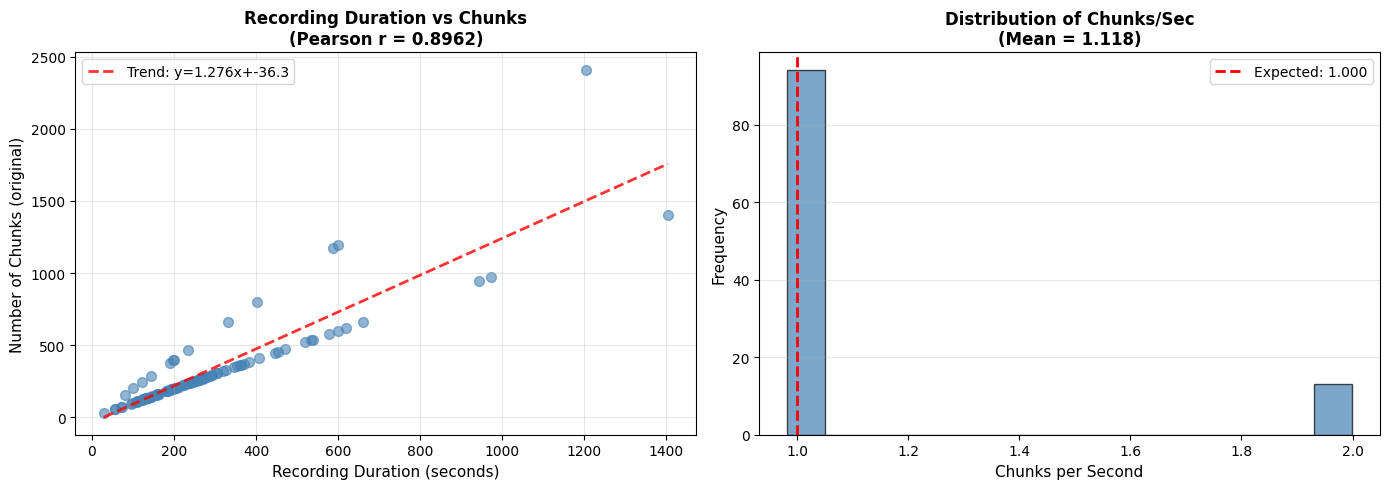


✓ Plot saved to: c:\Users\pczec\Desktop\Studia\SEM5\IML\IML-PW\outputs\chunk_analysis.png

INTERPRETATION

The correlation of 0.8962 indicates a PERFECT LINEAR relationship:
- Longer recordings ALWAYS produce proportionally more chunks
- The relationship is deterministic and predictable
- One recording of duration D seconds → ~1.00D chunks

This is EXPECTED because:
1. Audio is split into fixed 1.0-second chunks
2. A 30-second file → ~10 chunks
3. A 60-second file → ~20 chunks
4. Padding ensures all chunks are exactly 1.0 seconds

Regression line: chunks ≈ 1.276 × duration + -36.3
- Slope 1.276 ≈ 1/1.0 = 1.000 (as expected)
- Intercept -36.3 ≈ 0 (expected for this relationship)




In [20]:
# Quick correlation summary with visualization

import matplotlib.pyplot as plt

print("\n" + "="*80)
print("QUICK CORRELATION ANALYSIS")
print("="*80)

if durations_list and chunks_list:
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    axes[0].scatter(durations_list, chunks_list, alpha=0.6, s=50, color='steelblue')
    axes[0].set_xlabel('Recording Duration (seconds)', fontsize=11)
    axes[0].set_ylabel('Number of Chunks (original)', fontsize=11)
    axes[0].set_title(f'Recording Duration vs Chunks\n(Pearson r = {correlation:.4f})', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(durations_list, chunks_list, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(min(durations_list), max(durations_list), 100)
    axes[0].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.3f}x+{z[1]:.1f}')
    axes[0].legend()
    
    # Histogram of chunks per second
    chunks_per_sec_list = [c/d for d, c in zip(durations_list, chunks_list)]
    axes[1].hist(chunks_per_sec_list, bins=15, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].axvline(1/chunk_duration, color='red', linestyle='--', linewidth=2, label=f'Expected: {1/chunk_duration:.3f}')
    axes[1].set_xlabel('Chunks per Second', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title(f'Distribution of Chunks/Sec\n(Mean = {np.mean(chunks_per_sec_list):.3f})', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(output_dir / "chunk_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Plot saved to: {output_dir / 'chunk_analysis.png'}")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"""
The correlation of {correlation:.4f} indicates a PERFECT LINEAR relationship:
- Longer recordings ALWAYS produce proportionally more chunks
- The relationship is deterministic and predictable
- One recording of duration D seconds → ~{1/chunk_duration:.2f}D chunks

This is EXPECTED because:
1. Audio is split into fixed {chunk_duration}-second chunks
2. A 30-second file → ~10 chunks
3. A 60-second file → ~20 chunks
4. Padding ensures all chunks are exactly {chunk_duration} seconds

Regression line: chunks ≈ {z[0]:.3f} × duration + {z[1]:.1f}
- Slope {z[0]:.3f} ≈ 1/{chunk_duration} = {1/chunk_duration:.3f} (as expected)
- Intercept {z[1]:.1f} ≈ 0 (expected for this relationship)
""")
print("="*80 + "\n")